In [2]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

In [3]:
# Load environment variables from a .env file
load_dotenv()

# Use env vars for connection
db_user = os.getenv("DB_USER", "postgres")
db_password = os.getenv("DB_PASSWORD", "")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME", "portfolio_db")

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Example query
query = """
SELECT *
FROM target_ecommerce.orders
LIMIT 100;
"""

df = pd.read_sql_query(query, engine)
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

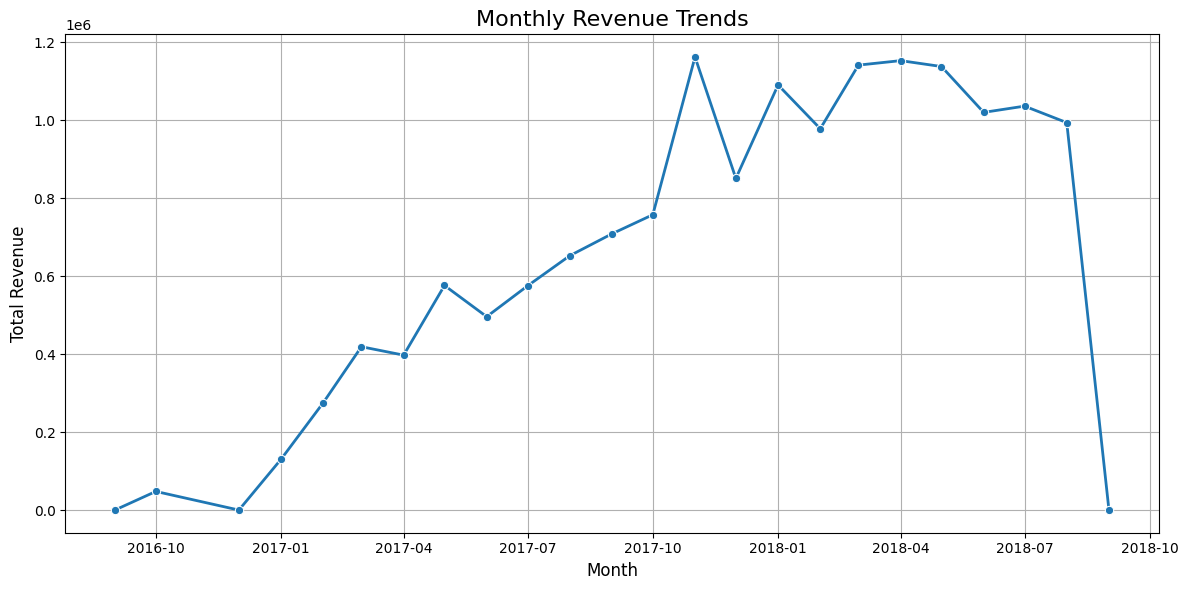

In [5]:
query = """
SELECT
    TO_CHAR(o.order_purchase_timestamp, 'YYYY-MM') AS order_year_month,
    SUM(COALESCE(p.payment_value, 0)) AS total_revenue
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.payments AS p ON o.order_id = p.order_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    order_year_month
ORDER BY
    order_year_month;
"""

df = pd.read_sql_query(query, engine)

df['order_year_month'] = pd.to_datetime(df['order_year_month'], format='%Y-%m')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='order_year_month', y='total_revenue', marker='o', linewidth=2)

plt.title('Monthly Revenue Trends', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('../visualisations/01_monthly_revenue_trend.png', dpi=300)
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_12152\3616157407.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='product_category', x='total_revenue', palette='viridis')


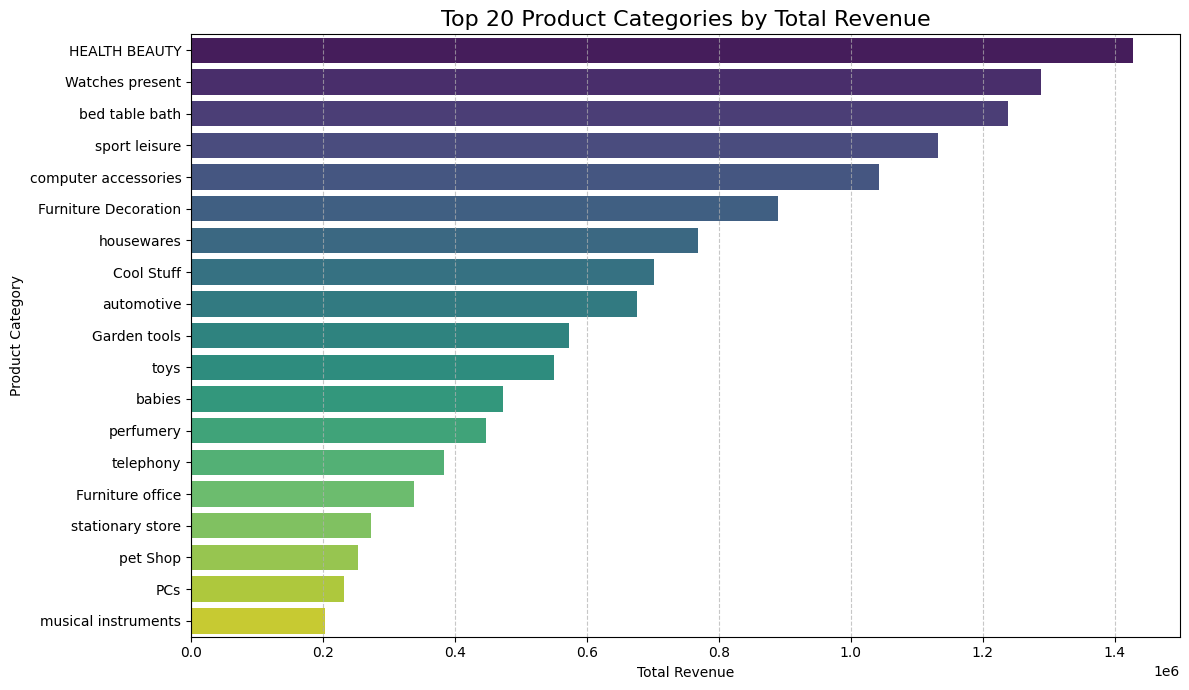

In [6]:
query = """
SELECT
    p.product_category,
    SUM(COALESCE(oi.price, 0) + COALESCE(oi.freight_value, 0)) AS total_revenue
FROM
    target_ecommerce.order_items AS oi
INNER JOIN
    target_ecommerce.orders AS o ON oi.order_id = o.order_id
INNER JOIN
    target_ecommerce.products AS p ON oi.product_id = p.product_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    p.product_category
ORDER BY
    total_revenue DESC
LIMIT 20;
"""

df = pd.read_sql_query(query, engine)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=df, y='product_category', x='total_revenue', palette='viridis')

plt.title('Top 20 Product Categories by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('../visualisations/01_revenue_by_top20_product_categories.png', dpi=300)

plt.show()

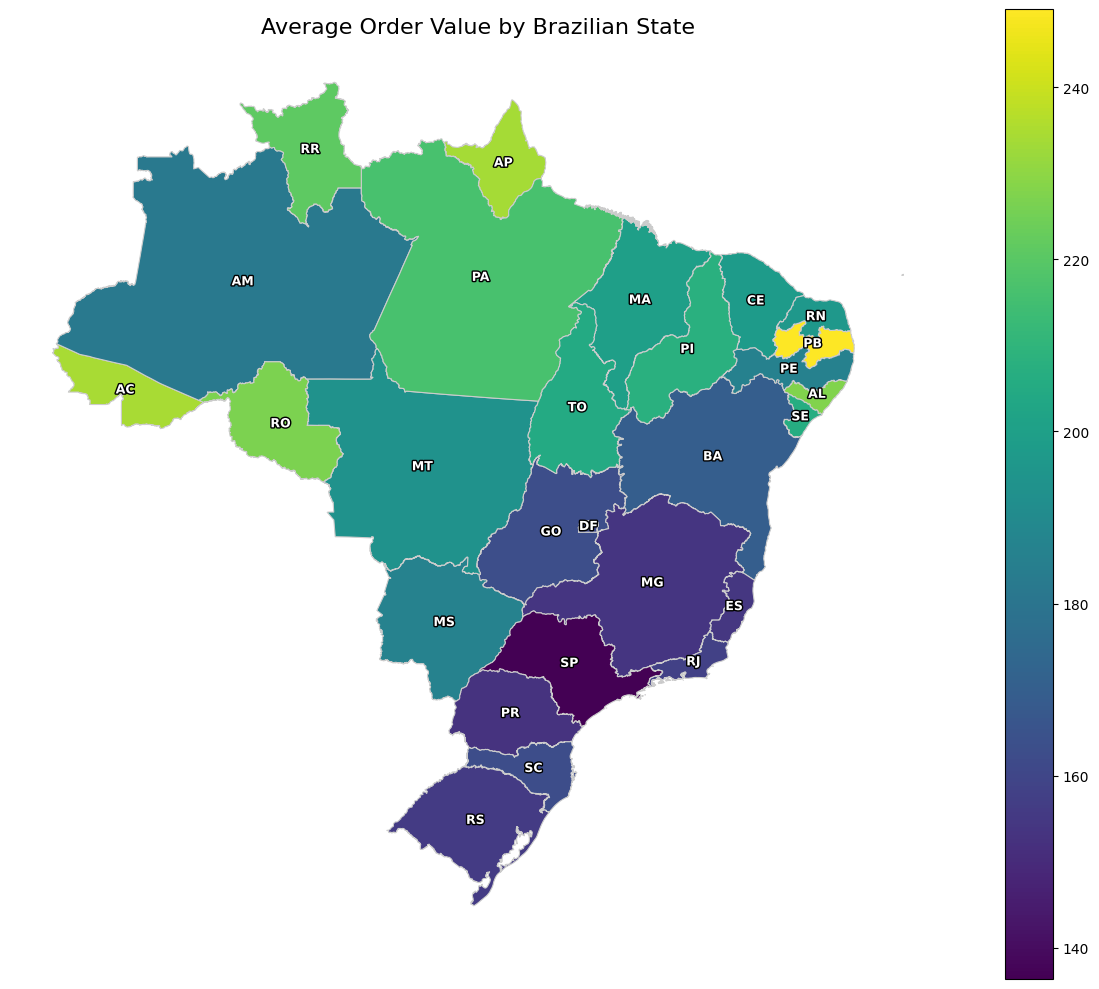

In [7]:
query = """
SELECT
    c.customer_state,
    AVG(COALESCE(p.payment_value, 0)) AS average_order_value
FROM
    target_ecommerce.payments AS p
INNER JOIN
    target_ecommerce.orders AS o ON p.order_id = o.order_id
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
WHERE
    o.order_status IN ('shipped', 'delivered')
GROUP BY
    c.customer_state
ORDER BY
    average_order_value DESC;
"""

df = pd.read_sql_query(query, engine)

# Load Brazil states geometry data
geo_path = '..\\data\\brazil-states.geojson'  # fixed slashes for Windows
gdf = gpd.read_file(geo_path)

# Rename df column to match shapefile state abbreviation column
df.rename(columns={'customer_state': 'sigla'}, inplace=True)

# Merge spatial data with your revenue data
merged = gdf.merge(df, on='sigla')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='average_order_value',
            cmap='viridis',
            linewidth=0.8,
            edgecolor='0.8',
            legend=True,
            ax=ax)

# Add labels with white text and black outline for readability
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['sigla'],
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])

ax.set_title('Average Order Value by Brazilian State', fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig('../visualisations/01_average_order_value.png', dpi=300)

plt.show()


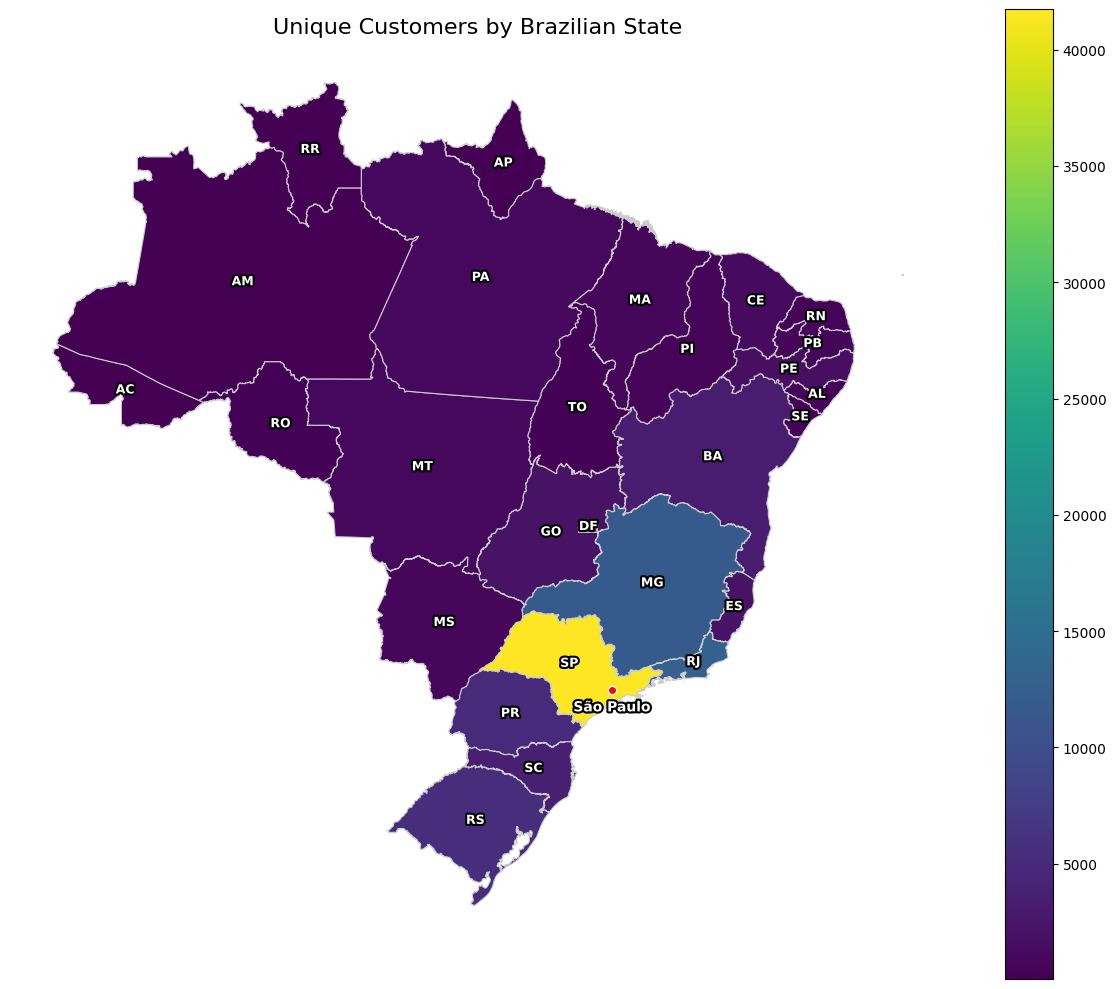

In [8]:
query = """
SELECT
    c.customer_state,
    COUNT(DISTINCT c.customer_id) AS unique_customers_count
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
GROUP BY
    c.customer_state
ORDER BY
    unique_customers_count DESC;
"""

df = pd.read_sql_query(query, engine)

# Load Brazil states geometry
geo_path = '..\\data\\brazil-states.geojson'
gdf = gpd.read_file(geo_path)

# Match column for merging
df.rename(columns={'customer_state': 'sigla'}, inplace=True)

# Merge geographic and customer data
merged = gdf.merge(df, on='sigla')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='unique_customers_count',
            cmap='viridis',
            linewidth=0.8,
            edgecolor='0.8',
            legend=True,
            ax=ax)

# Add state labels with outlines for visibility
for idx, row in merged.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['sigla'],
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            fontweight='bold',
            color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])

# Add a custom marker and label for São Paulo city
sp_lon, sp_lat = -46.6333, -23.5505

# Plot marker
ax.plot(sp_lon, sp_lat, marker='o', markersize=6, color='red', markeredgecolor='white', zorder=5)

# Add label
ax.text(sp_lon, sp_lat - 0.8, 'São Paulo',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=10,
        fontweight='bold',
        color='white',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='black')],
        zorder=6)


ax.set_title('Unique Customers by Brazilian State', fontsize=16)
ax.axis('off')

plt.tight_layout()

plt.savefig('../visualisations/02_unique_customers_by_state.png', dpi=300)

plt.show()

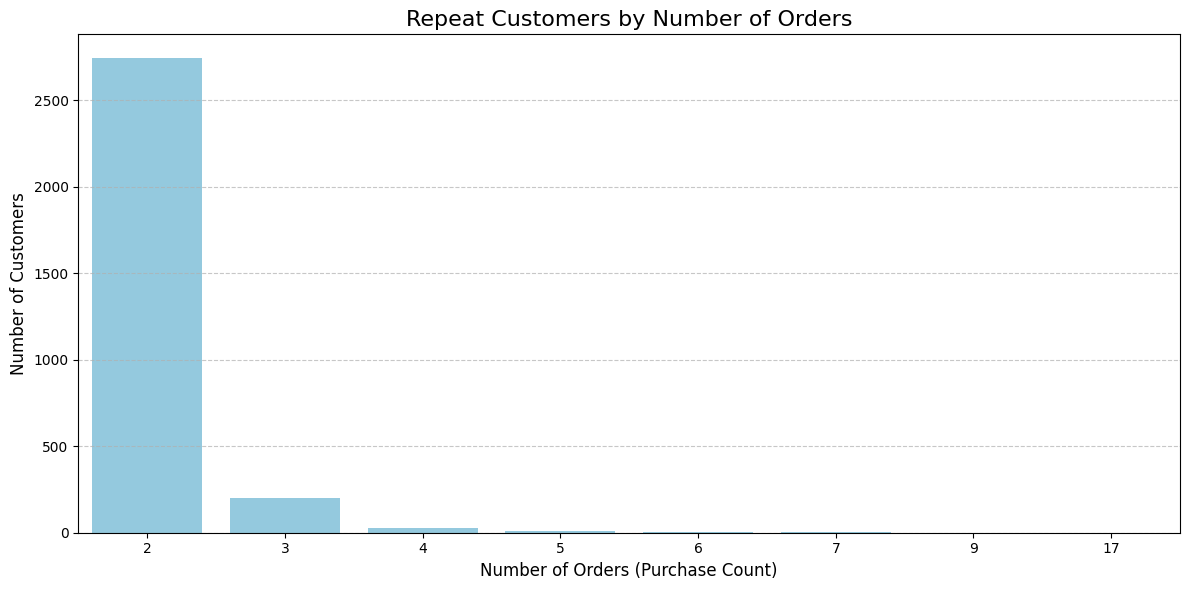

In [9]:
# Query: Frequency distribution of repeat customers
query = """
SELECT
    num_orders AS purchase_count,
    COUNT(*) AS customer_count
FROM (
    SELECT
        c.customer_unique_id,
        COUNT(DISTINCT o.order_id) AS num_orders
    FROM
        target_ecommerce.orders AS o
    LEFT JOIN
        target_ecommerce.customers AS c ON o.customer_id = c.customer_id
    GROUP BY
        c.customer_unique_id
) AS customer_orders
GROUP BY
    num_orders
ORDER BY
    num_orders;
"""

# Load data
df = pd.read_sql_query(query, engine)

# Filter out one-time customers
df = df[df['purchase_count'] > 1]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='purchase_count', y='customer_count', color='skyblue')

plt.title('Repeat Customers by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders (Purchase Count)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('../visualisations/02_repeat_customers_by_order_count.png', dpi=300)

plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_12152\2386018347.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='segment', y='avg_orders', ax=axes[0], palette='viridis')
C:\Users\james\AppData\Local\Temp\ipykernel_12152\2386018347.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='segment', y='avg_spent', ax=axes[1], palette='viridis')


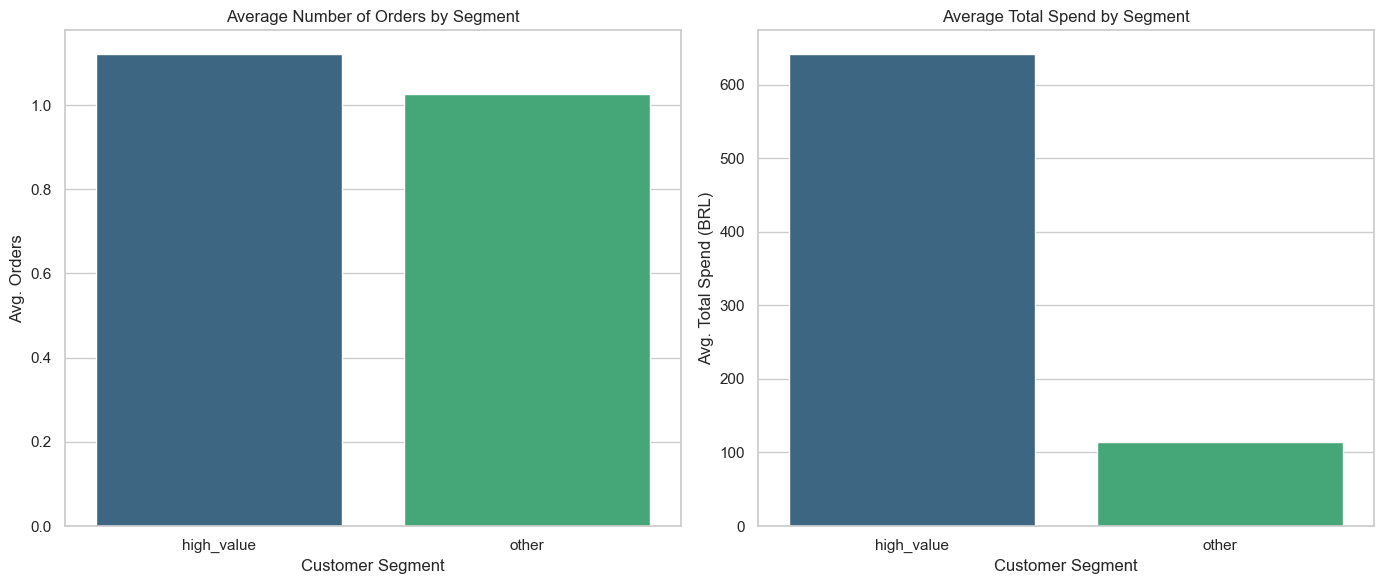

In [10]:
query = """
WITH customer_spend AS (
    SELECT
        c.customer_unique_id,
        SUM(p.payment_value) AS total_spent,
        COUNT(DISTINCT o.order_id) AS num_orders
    FROM
        target_ecommerce.orders AS o
    INNER JOIN
        target_ecommerce.payments AS p ON o.order_id = p.order_id
    LEFT JOIN
        target_ecommerce.customers AS c ON o.customer_id = c.customer_id
    GROUP BY
        c.customer_unique_id
),
spend_threshold AS (
    SELECT
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY total_spent) AS threshold
    FROM
        customer_spend
),
segmented_customers AS (
    SELECT
        cs.*,
        CASE
            WHEN cs.total_spent >= st.threshold THEN 'high_value'
            ELSE 'other'
        END AS segment
    FROM
        customer_spend AS cs
    CROSS JOIN
        spend_threshold AS st
)
SELECT
    segment,
    COUNT(*) AS customer_count,
    AVG(num_orders) AS avg_orders,
    AVG(total_spent) AS avg_spent
FROM
    segmented_customers
GROUP BY
    segment;
"""

df = pd.read_sql_query(query, engine)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart 1: Average Orders
sns.barplot(data=df, x='segment', y='avg_orders', ax=axes[0], palette='viridis')
axes[0].set_title('Average Number of Orders by Segment')
axes[0].set_ylabel('Avg. Orders')
axes[0].set_xlabel('Customer Segment')

# Bar chart 2: Average Spend
sns.barplot(data=df, x='segment', y='avg_spent', ax=axes[1], palette='viridis')
axes[1].set_title('Average Total Spend by Segment')
axes[1].set_ylabel('Avg. Total Spend (BRL)')
axes[1].set_xlabel('Customer Segment')

plt.tight_layout()

plt.savefig('../visualisations/02_order_count_and_total_spend.png', dpi=300)

plt.show()


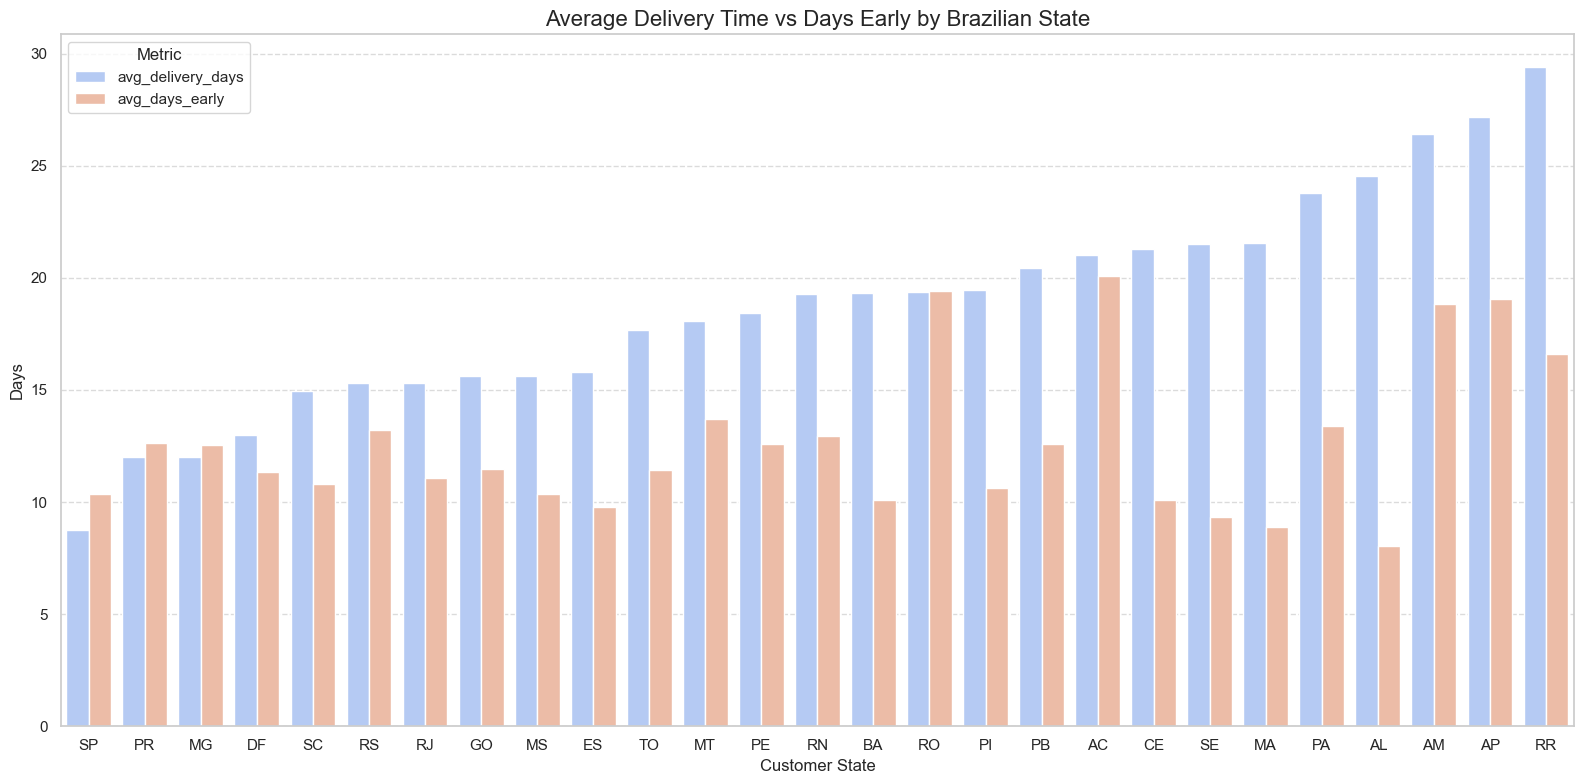

In [11]:
# --- Load both query results ---
query_delivery = """
SELECT
    c.customer_state,
    ROUND(
        AVG(EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400),
        2
    ) AS avg_delivery_days
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
WHERE
    o.order_delivered_customer_date IS NOT NULL
    AND o.order_purchase_timestamp IS NOT NULL
GROUP BY
    c.customer_state
"""

query_delay = """
SELECT
    c.customer_state,
    ROUND(
        AVG(EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400),
        2
    ) AS avg_delay_days
FROM
    target_ecommerce.orders AS o
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
WHERE
    o.order_delivered_customer_date IS NOT NULL
    AND o.order_estimated_delivery_date IS NOT NULL
GROUP BY
    c.customer_state
"""

df_delivery = pd.read_sql_query(query_delivery, engine)
df_delay = pd.read_sql_query(query_delay, engine)
df_delay['avg_days_early'] = df_delay['avg_delay_days']*-1

df_combined = pd.merge(df_delivery, df_delay, on='customer_state')

df_combined.sort_values('avg_delivery_days', inplace=True)

df_melted = df_combined.melt(id_vars='customer_state', 
                             value_vars=['avg_delivery_days', 'avg_days_early'],
                             var_name='metric', 
                             value_name='days')

# Plotting
plt.figure(figsize=(16, 8))
sns.barplot(data=df_melted, x='customer_state', y='days', hue='metric', palette='coolwarm')

plt.title('Average Delivery Time vs Days Early by Brazilian State', fontsize=16)
plt.xlabel('Customer State')
plt.ylabel('Days')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('../visualisations/03_delivery_bar_chart.png', dpi=300)

plt.show()

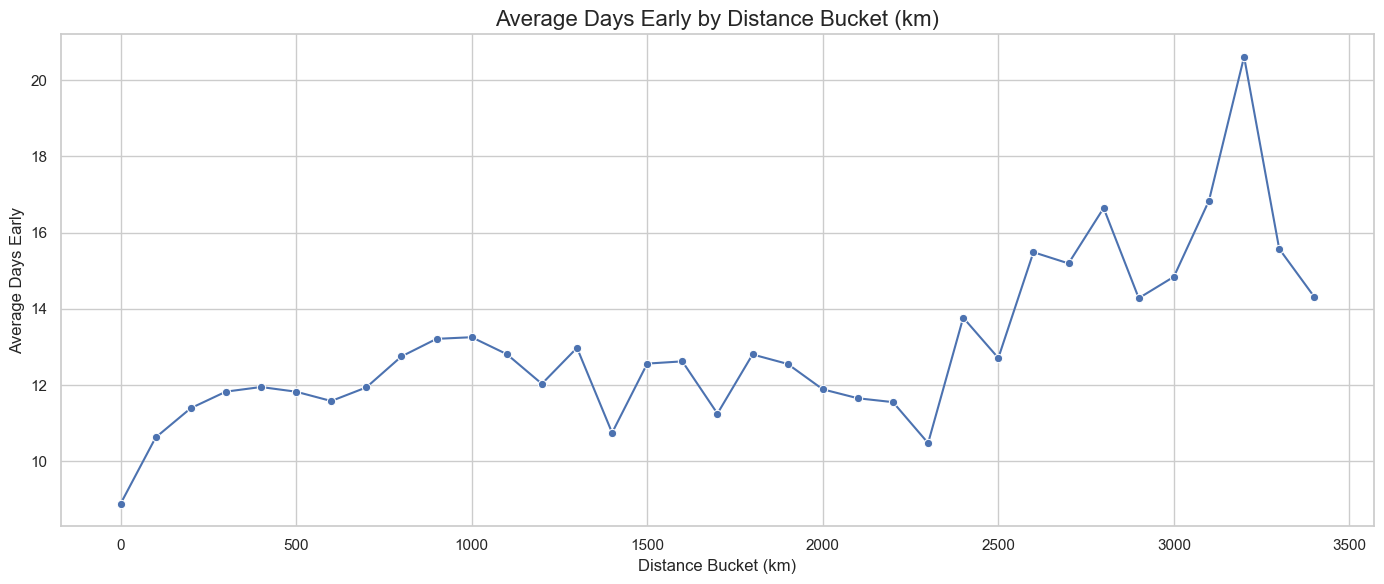

C:\Users\james\AppData\Local\Temp\ipykernel_12152\1874882275.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='distance_bucket_km', y='num_orders', palette='viridis')


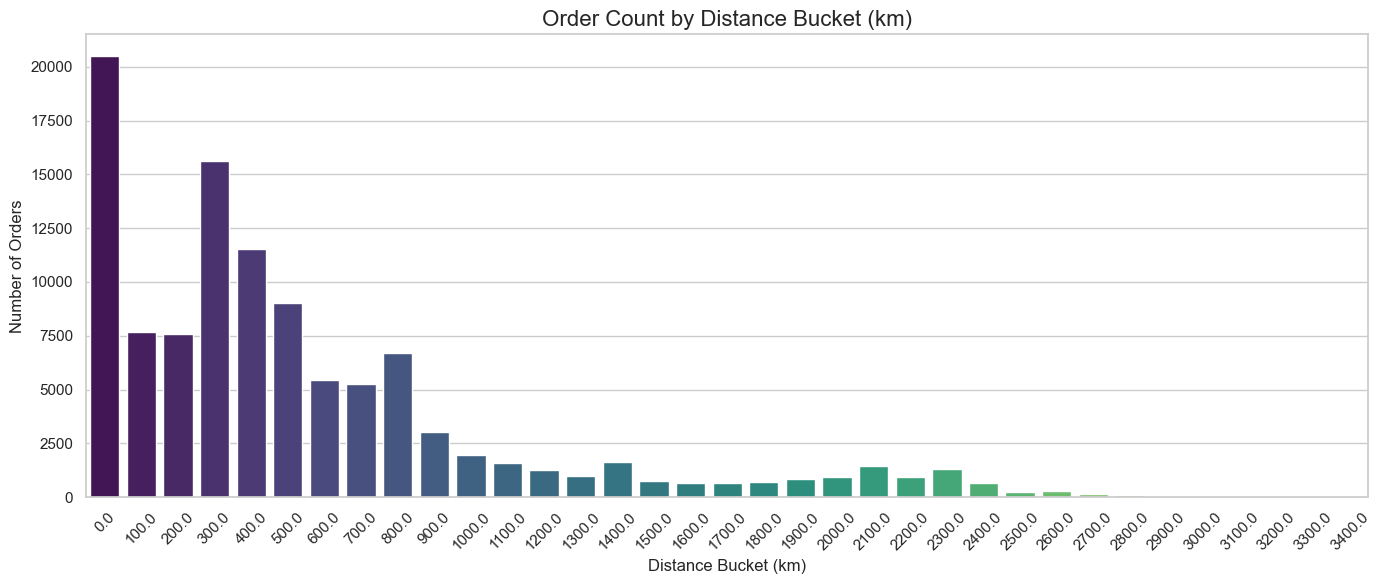

In [12]:
query = """
WITH geo AS (
    SELECT
        geolocation_zip_code_prefix,
        AVG(geolocation_lat) AS lat,
        AVG(geolocation_lng) AS lng
    FROM
        target_ecommerce.geolocation
    GROUP BY
        geolocation_zip_code_prefix
),

customer_locs AS (
    SELECT
        c.customer_id,
        g.lat AS customer_lat,
        g.lng AS customer_lng
    FROM
        target_ecommerce.customers AS c
    INNER JOIN
        geo AS g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
),

seller_locs AS (
    SELECT
        s.seller_id,
        g.lat AS seller_lat,
        g.lng AS seller_lng
    FROM
        target_ecommerce.sellers AS s
    INNER JOIN
        geo AS g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
),

order_pairs AS (
    SELECT
        o.order_id,
        o.customer_id,
        oi.seller_id,
        o.order_delivered_customer_date,
        o.order_estimated_delivery_date
    FROM
        target_ecommerce.orders AS o
    INNER JOIN
        target_ecommerce.order_items AS oi ON o.order_id = oi.order_id
    WHERE
        o.order_delivered_customer_date IS NOT NULL
        AND o.order_estimated_delivery_date IS NOT NULL
),

order_with_locations AS (
    SELECT
        op.*,
        cl.customer_lat,
        cl.customer_lng,
        sl.seller_lat,
        sl.seller_lng
    FROM
        order_pairs AS op
    INNER JOIN
        customer_locs AS cl ON op.customer_id = cl.customer_id
    INNER JOIN
        seller_locs AS sl ON op.seller_id = sl.seller_id
),

order_with_distance AS (
    SELECT
        *,
        6371 * 2 * ASIN(
            SQRT(
                POWER(SIN(RADIANS((customer_lat - seller_lat) / 2)), 2) +
                COS(RADIANS(seller_lat)) * COS(RADIANS(customer_lat)) *
                POWER(SIN(RADIANS((customer_lng - seller_lng) / 2)), 2)
            )
        ) AS distance_km,
        EXTRACT(EPOCH FROM (order_delivered_customer_date - order_estimated_delivery_date)) / 86400 AS delivery_delay_days
    FROM
        order_with_locations
)

SELECT
    FLOOR(distance_km / 100) * 100 AS distance_bucket_km,
    AVG(delivery_delay_days) AS avg_delivery_delay_days,
    COUNT(*) AS num_orders
FROM
    order_with_distance
WHERE
    distance_km <= 3500
GROUP BY
    FLOOR(distance_km / 100) * 100
ORDER BY
    distance_bucket_km;
"""

# Run query and load data
df = pd.read_sql_query(query, engine)
df['avg_days_early'] = df['avg_delivery_delay_days']*-1

# Line Chart: Average Delivery Delay vs Distance Bucket
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='distance_bucket_km', y='avg_days_early', marker='o')
plt.title('Average Days Early by Distance Bucket (km)', fontsize=16)
plt.xlabel('Distance Bucket (km)')
plt.ylabel('Average Days Early')
plt.grid(True)
plt.tight_layout()
plt.savefig('../visualisations/03_avg_days_early.png', dpi=300)
plt.show()

# Histogram: Order Count by Distance Bucket
plt.figure(figsize=(14,6))
sns.barplot(data=df, x='distance_bucket_km', y='num_orders', palette='viridis')
plt.title('Order Count by Distance Bucket (km)', fontsize=16)
plt.xlabel('Distance Bucket (km)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../visualisations/03_count_by_distance.png', dpi=300)
plt.show()

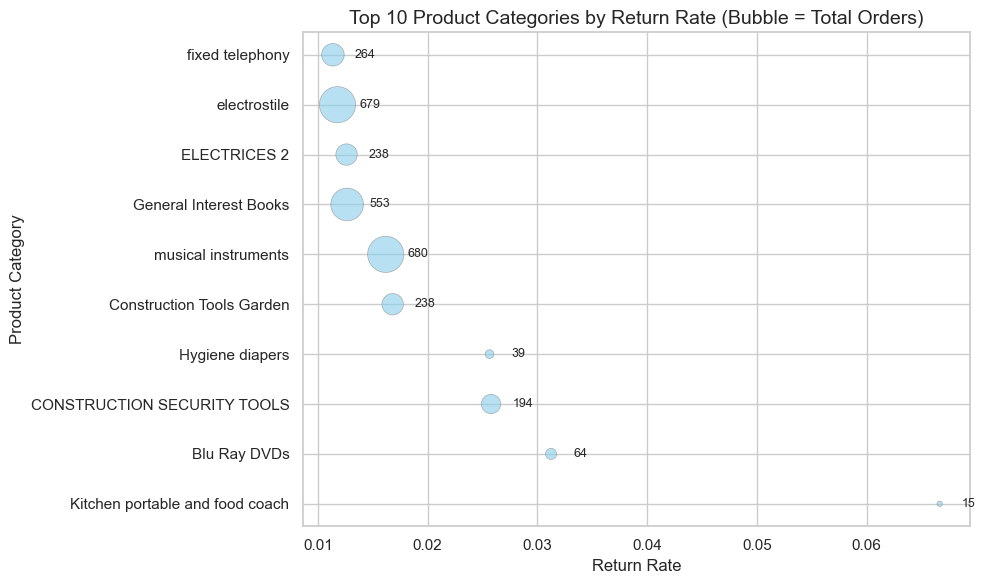

In [25]:
query = """
SELECT
    p.product_category,
    COUNT(*) FILTER (WHERE o.order_status IN ('canceled', 'unavailable'))::float / COUNT(*) AS return_rate,
    COUNT(*) AS total_orders
FROM
    target_ecommerce.order_items AS oi
INNER JOIN
    target_ecommerce.orders AS o ON oi.order_id = o.order_id
INNER JOIN
    target_ecommerce.products AS p ON oi.product_id = p.product_id
GROUP BY
    p.product_category
HAVING
    COUNT(*) > 10
    AND COUNT(*) FILTER (WHERE o.order_status IN ('canceled', 'unavailable'))::float / COUNT(*) > 0
ORDER BY
    return_rate DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, engine)
df = df.sort_values(by="return_rate", ascending=False)

plt.figure(figsize=(10, 6))

# Plotting 
scatter = plt.scatter(
    x=df["return_rate"],
    y=df["product_category"],
    s=df["total_orders"],
    alpha=0.6,
    color='skyblue',
    edgecolors='gray',
    linewidth=0.5
)

for i, row in df.iterrows():
    plt.text(row["return_rate"] + 0.002, row["product_category"], f"{int(row['total_orders'])}", 
             va='center', fontsize=9)

plt.xlabel("Return Rate", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.title("Top 10 Product Categories by Return Rate (Bubble = Total Orders)", fontsize=14)
plt.tight_layout()

plt.savefig('../visualisations/04_product_return_rate.png', dpi=300)

plt.show()

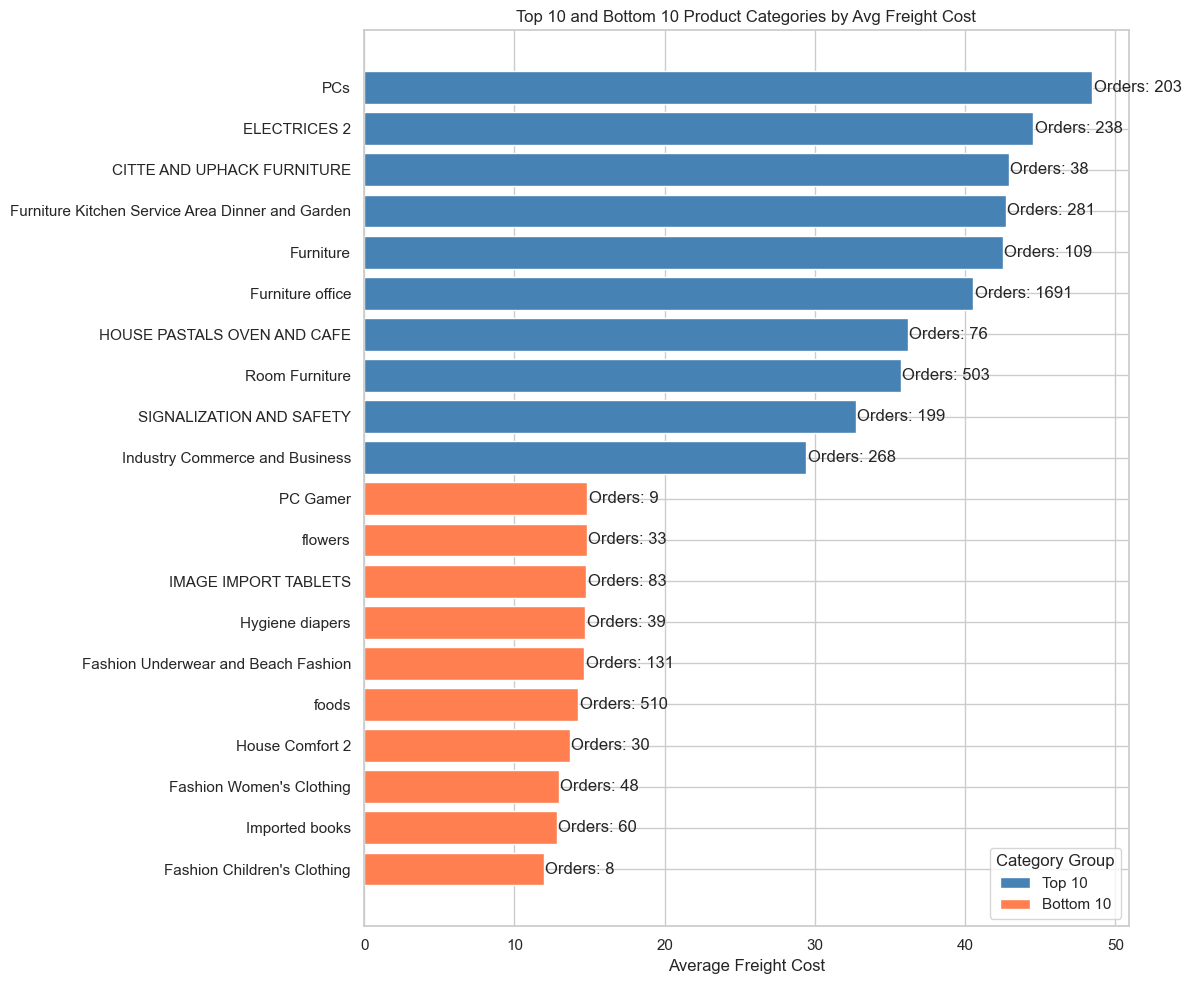

In [34]:
query = """
SELECT
    p.product_category,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight_cost,
    COUNT(*) AS num_orders
FROM
    target_ecommerce.order_items AS oi
INNER JOIN
    target_ecommerce.products AS p ON oi.product_id = p.product_id
GROUP BY
    p.product_category
ORDER BY
    avg_freight_cost DESC;
"""

df = pd.read_sql_query(query, engine)

top10 = df.head(10)
bottom10 = df.tail(10)

top10 = top10.assign(group='Top 10')
bottom10 = bottom10.assign(group='Bottom 10')
combined = pd.concat([top10, bottom10])

combined = combined.sort_values(by='avg_freight_cost', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
colors = {'Top 10': 'steelblue', 'Bottom 10': 'coral'}

bars = ax.barh(combined['product_category'], combined['avg_freight_cost'],
               color=combined['group'].map(colors))

ax.invert_yaxis()
ax.set_xlabel('Average Freight Cost')
ax.set_title('Top 10 and Bottom 10 Product Categories by Avg Freight Cost')

for bar, orders in zip(bars, combined['num_orders']):
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f'Orders: {orders}', va='center')

legend_elements = [Patch(facecolor=colors[g], label=g) for g in colors]
ax.legend(handles=legend_elements, title='Category Group')

plt.tight_layout()

plt.savefig('../visualisations/04_product_cat_avg_freight.png', dpi=300)

plt.show()

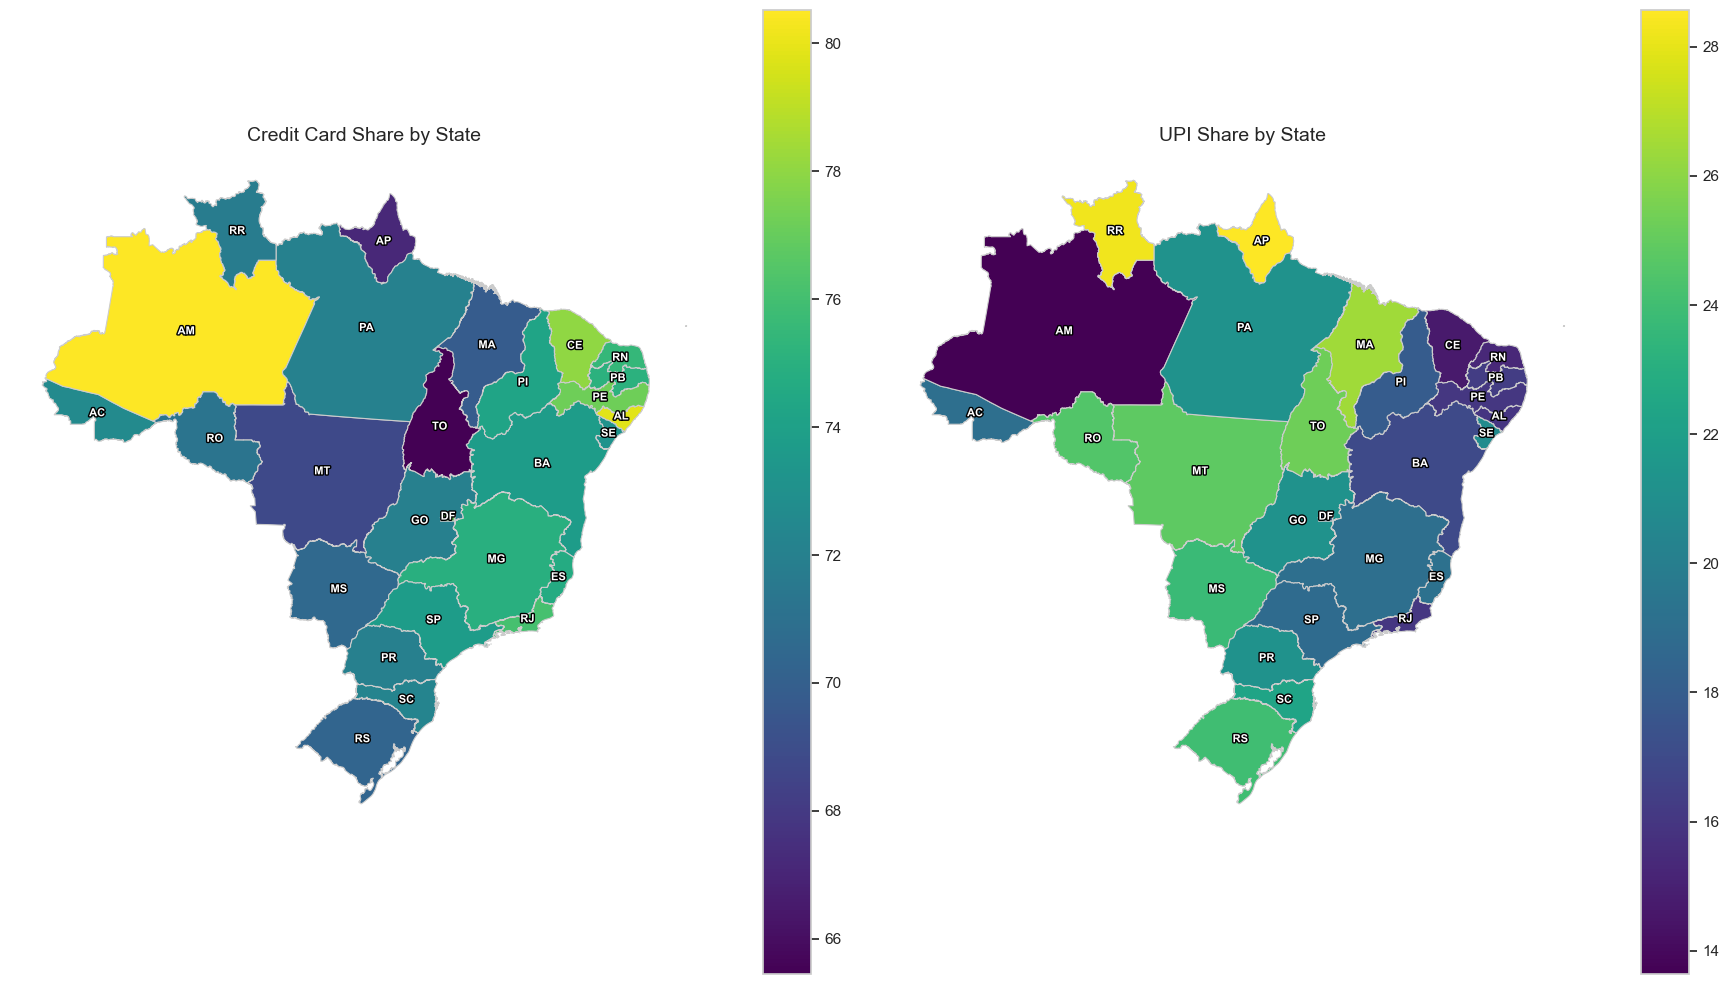

In [43]:
query = """
SELECT
    c.customer_state,
    p.payment_type,
    COUNT(*) AS payment_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY c.customer_state), 2) AS percent_of_state
FROM
    target_ecommerce.payments AS p
INNER JOIN
    target_ecommerce.orders AS o ON p.order_id = o.order_id
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
GROUP BY
    c.customer_state, p.payment_type
ORDER BY
    c.customer_state, payment_count DESC;
"""

payment_df = pd.read_sql_query(query, engine)

# Pivot to wide format for choropleth
pivot_df = payment_df[payment_df['payment_type'].isin(['credit_card', 'UPI'])].pivot(
    index='customer_state',
    columns='payment_type',
    values='percent_of_state'
).reset_index()

pivot_df.rename(columns={'customer_state': 'sigla'}, inplace=True)

# Load Brazil states geometry
geo_path = '..\\data\\brazil-states.geojson'
gdf = gpd.read_file(geo_path)

# Merge with geospatial data
merged = gdf.merge(pivot_df, on='sigla')

# Plot side-by-side choropleths
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for ax, col, title in zip(axes, ['credit_card', 'UPI'], ['Credit Card Share by State', 'UPI Share by State']):
    merged.plot(column=col,
                cmap='viridis',
                linewidth=0.8,
                edgecolor='0.8',
                legend=True,
                ax=ax)
    
    for idx, row in merged.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['sigla'],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,
                fontweight='bold',
                color='white',
                path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
    
    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.tight_layout()

plt.savefig('../visualisations/05_credit_card_upi_share.png', dpi=300)

plt.show()

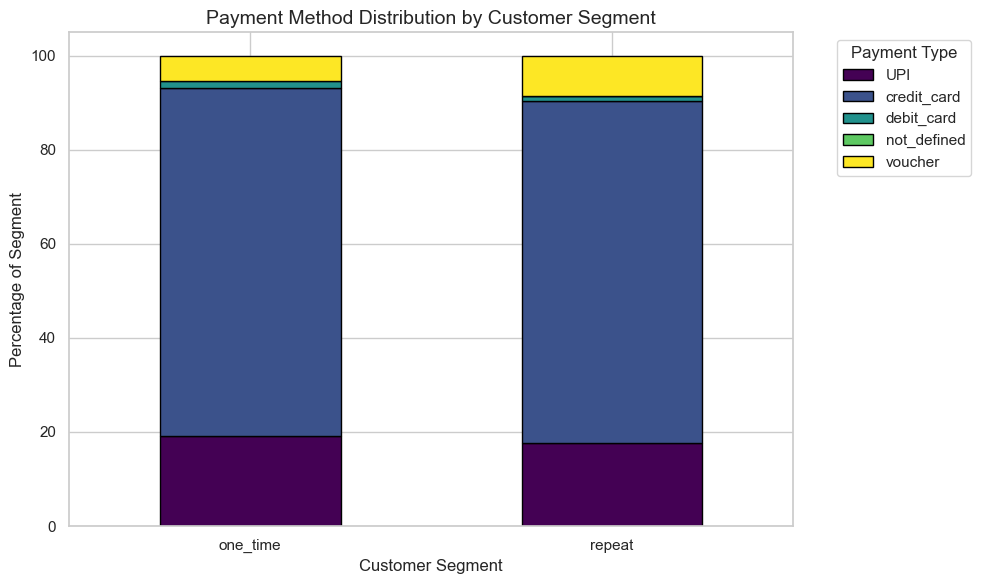

In [46]:
query = """
-- Most commonly used payment types by customer segment
WITH customer_segments AS (
    SELECT
        c.customer_unique_id,
        CASE 
            WHEN COUNT(DISTINCT o.order_id) > 1 THEN 'repeat'
            ELSE 'one_time'
        END AS segment
    FROM
        target_ecommerce.orders AS o
    INNER JOIN
        target_ecommerce.customers AS c ON o.customer_id = c.customer_id
    GROUP BY
        c.customer_unique_id
)
SELECT
    cs.segment,
    p.payment_type,
    COUNT(*) AS payment_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY cs.segment), 2) AS percent_of_segment
FROM
    target_ecommerce.payments AS p
INNER JOIN
    target_ecommerce.orders AS o ON p.order_id = o.order_id
INNER JOIN
    target_ecommerce.customers AS c ON o.customer_id = c.customer_id
INNER JOIN
    customer_segments AS cs ON c.customer_unique_id = cs.customer_unique_id
GROUP BY
    cs.segment, p.payment_type
ORDER BY
    cs.segment, payment_count DESC;
"""

segment_df = pd.read_sql_query(query, engine)

# Prepare data for stacked bar plot
pivot_seg = segment_df.pivot(index='segment', columns='payment_type', values='percent_of_segment').fillna(0)

# Sort for consistent segment order
pivot_seg = pivot_seg.loc[['one_time', 'repeat']]

# Plot
pivot_seg.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', edgecolor='black')

plt.title('Payment Method Distribution by Customer Segment', fontsize=14)
plt.ylabel('Percentage of Segment')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('../visualisations/05_payment_method_share.png', dpi=300)

plt.show()


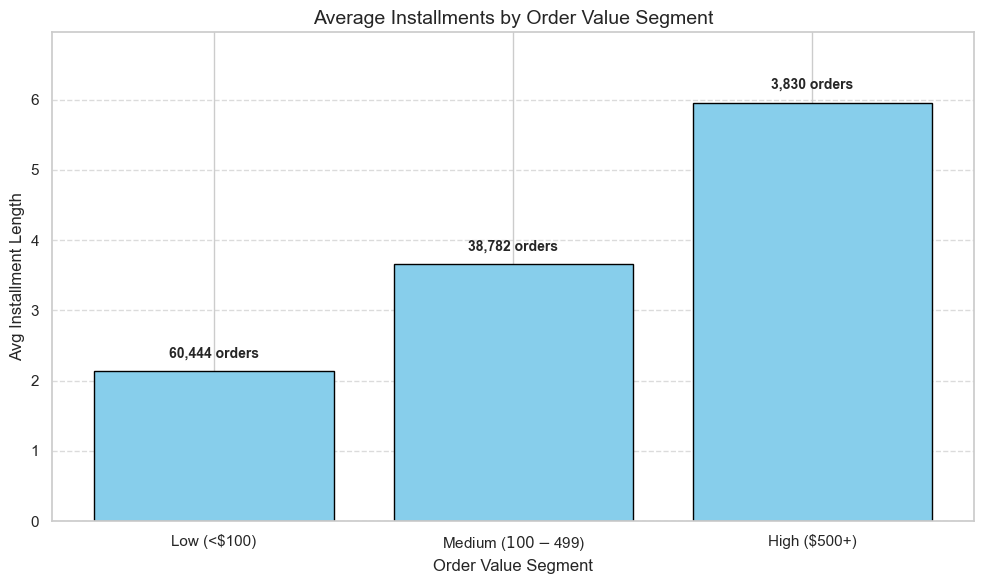

In [48]:
query = """
-- Average instalments by order value segment
SELECT
    CASE
        WHEN o.total_value < 100 THEN 'Low (<$100)'
        WHEN o.total_value < 500 THEN 'Medium ($100-$499)'
        ELSE 'High ($500+)'
    END AS value_segment,
    ROUND(AVG(p.payment_installments), 2) AS avg_installments,
    COUNT(*) AS num_orders
FROM (
    SELECT
        o.order_id,
        SUM(oi.price) AS total_value
    FROM
        target_ecommerce.orders AS o
    INNER JOIN
        target_ecommerce.order_items AS oi ON o.order_id = oi.order_id
    GROUP BY
        o.order_id
) AS o
INNER JOIN
    target_ecommerce.payments AS p ON o.order_id = p.order_id
GROUP BY
    value_segment
ORDER BY
    avg_installments;
"""

df = pd.read_sql_query(query, engine)

# Sort by average installments for visual clarity
df = df.sort_values(by='avg_installments', ascending=True)

# Create the grouped bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(df['value_segment'], df['avg_installments'], color='skyblue', edgecolor='black')

# Add annotations for num_orders above each bar
for bar, orders in zip(bars, df['num_orders']):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.15,
             f'{orders:,} orders',
             ha='center',
             va='bottom',
             fontsize=10,
             fontweight='bold')

# Labels and title
ax1.set_title('Average Installments by Order Value Segment', fontsize=14)
ax1.set_ylabel('Avg Installment Length')
ax1.set_xlabel('Order Value Segment')
ax1.set_ylim(0, max(df['avg_installments']) + 1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('../visualisations/05_avg_instalments.png', dpi=300)

plt.show()

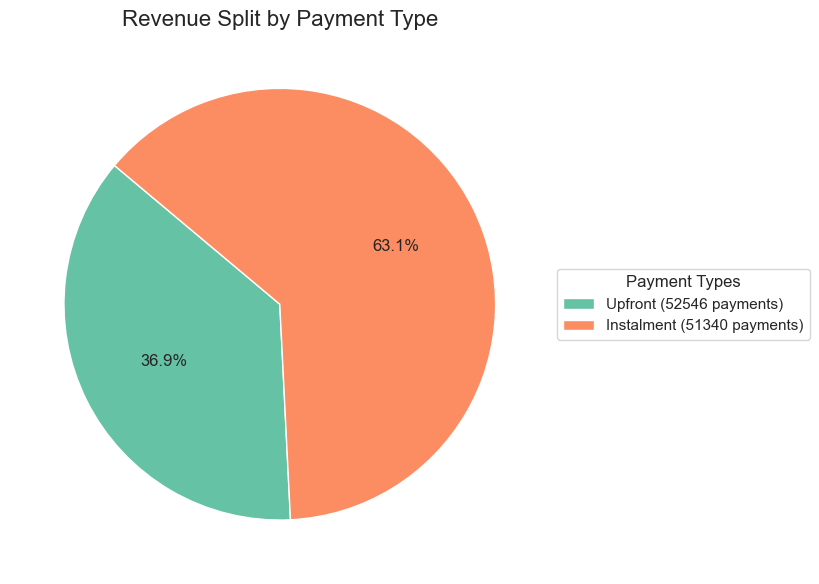

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your SQL query
query = """
SELECT
    CASE
        WHEN p.payment_installments = 1 THEN 'upfront'
        ELSE 'instalment'
    END AS payment_type,
    ROUND(SUM(p.payment_value), 2) AS total_revenue,
    COUNT(*) AS num_payments
FROM
    target_ecommerce.payments AS p
GROUP BY
    CASE
        WHEN p.payment_installments = 1 THEN 'upfront'
        ELSE 'instalment'
    END;
"""

df = pd.read_sql_query(query, engine)

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#66c2a5', '#fc8d62']

wedges, texts, autotexts = ax.pie(
    df['total_revenue'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(edgecolor='w')
)

# Title and legend
ax.set_title('Revenue Split by Payment Type', fontsize=16)
plt.legend(wedges, [f"{row['payment_type'].capitalize()} ({row['num_payments']} payments)" for _, row in df.iterrows()],
           title="Payment Types",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()

plt.savefig('../visualisations/05_revenue_split.png', dpi=300)

plt.show()